In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sklearn
from sklearn.model_selection import train_test_split

# 0. Dataset 전처리

In [ ]:
# Load the Titanic dataset
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/titanic_train.csv")

# Preprocess the data
df = df.dropna()

df.head()

In [ ]:
X = df[["Pclass", "Sex", "Age", "Fare"]]
y = df["Survived"]

# Convert categorical features to one-hot encoding
X = pd.get_dummies(X, columns=["Sex"], dtype='int').values
y = y.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train[:5])
print(y_train[:5])

# 1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

# 2. Neural Network with FC Layers

In [15]:
# Define torch Dataset
class MyTitanicDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.x_data.shape[0]

dataset = MyTitanicDataset(X_train, y_train)

In [33]:
# Define the neural network architecture
class MyClassificationModel(nn.Module):
    def __init__(self):
        super(MyClassificationModel, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 선언
model = MyClassificationModel()

In [34]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create a data loader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [35]:
from tqdm import tqdm

# Train the model
losses = []

for epoch in range(100):
    for i, (x, y) in enumerate(dataloader):
        # Forward pass
        y_pred = model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, Loss: {loss.item():.4f}")

Epoch: 1, Batch: 0, Loss: 2.5887
Epoch: 1, Batch: 10, Loss: 2.2278
Epoch: 2, Batch: 0, Loss: 1.4648
Epoch: 2, Batch: 10, Loss: 0.9156
Epoch: 3, Batch: 0, Loss: 0.7727
Epoch: 3, Batch: 10, Loss: 0.8642
Epoch: 4, Batch: 0, Loss: 1.0533
Epoch: 4, Batch: 10, Loss: 0.5926
Epoch: 5, Batch: 0, Loss: 0.9372
Epoch: 5, Batch: 10, Loss: 0.5470
Epoch: 6, Batch: 0, Loss: 0.9007
Epoch: 6, Batch: 10, Loss: 0.6684
Epoch: 7, Batch: 0, Loss: 0.5743
Epoch: 7, Batch: 10, Loss: 0.6703
Epoch: 8, Batch: 0, Loss: 0.7210
Epoch: 8, Batch: 10, Loss: 0.6336
Epoch: 9, Batch: 0, Loss: 0.4883
Epoch: 9, Batch: 10, Loss: 0.4999
Epoch: 10, Batch: 0, Loss: 0.5656
Epoch: 10, Batch: 10, Loss: 0.8337
Epoch: 11, Batch: 0, Loss: 0.4293
Epoch: 11, Batch: 10, Loss: 0.5149
Epoch: 12, Batch: 0, Loss: 0.5278
Epoch: 12, Batch: 10, Loss: 0.6678
Epoch: 13, Batch: 0, Loss: 0.6202
Epoch: 13, Batch: 10, Loss: 0.5536
Epoch: 14, Batch: 0, Loss: 0.7295
Epoch: 14, Batch: 10, Loss: 0.6962
Epoch: 15, Batch: 0, Loss: 0.5966
Epoch: 15, Batch: 

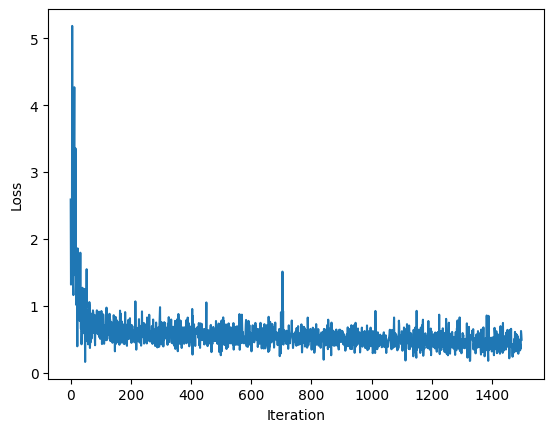

In [36]:
# Loss Graph 시각화
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 3. 모델 평가

### Logistic Regression Model

In [28]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

y_pred = lr_model.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))
print('precision : ', precision_score(y_pred, y_test))
print('recall : ', recall_score(y_pred, y_test))
print('f1 : ', f1_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

Accuracy :  0.7027027027027027
precision :  0.7777777777777778
recall :  0.8076923076923077
f1 :  0.7924528301886792
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.78      0.81      0.79        26

    accuracy                           0.70        37
   macro avg       0.64      0.63      0.63        37
weighted avg       0.70      0.70      0.70        37



### Neural Network

In [37]:
# Evaluate the network
nn_y_pred = []

with torch.no_grad(): # model.eval()
    for x, y in zip(X_test, y_test):
        outputs = model(torch.tensor([x], dtype=torch.float32))
        _, predicted = torch.max(outputs.data, 1)
        nn_y_pred.append(predicted.detach().cpu().item())


print('Accuracy : ', accuracy_score(nn_y_pred, y_test))
print('precision : ', precision_score(nn_y_pred, y_test))
print('recall : ', recall_score(nn_y_pred, y_test))
print('f1 : ', f1_score(nn_y_pred, y_test))
print(classification_report(nn_y_pred, y_test))

Accuracy :  0.6486486486486487
precision :  0.7407407407407407
recall :  0.7692307692307693
f1 :  0.7547169811320754
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.74      0.77      0.75        26

    accuracy                           0.65        37
   macro avg       0.57      0.57      0.57        37
weighted avg       0.64      0.65      0.64        37

